# make training set
- randomly sample frames from video
- perform k-means clustering to select distinct frames
- save as dataset than can be subsequently labelled
- OR merge frames with an existing dataset

## find frames

In [1]:
# initialization
from deepposekit.io import VideoReader, DataGenerator, initialize_dataset
from deepposekit.io.utils import merge_new_images
from deepposekit.annotate import KMeansSampler
from tqdm.notebook import tqdm
from os.path import join
import pandas as pd
import numpy as np
import os
%load_ext autoreload
%autoreload 2

# settings
git_dir = r'D:\github\fish-tracking'
dataset_name = 'tank_dataset_2'
skeleton = r'D:\github\fish-tracking\label\skeletons\tank_skeleton_3.csv'
video = r'Z:\locker\ShareData\tank_for_rick\tank_vids\20201011_Igor\time_h16m36s42\videoEOD_cropped002.avi'  # frames are picked from this video
n_frames = 20  # frames to include in training set
n_random_frames = 1000  # perform clustering on random sub sample of n_random_frames

In [2]:
# sample random frames from video
reader = VideoReader(video, gray=True, batch_size=1)
random_frames = []
n_random_frames = min(n_random_frames, len(reader))
random_idxs = np.sort(np.random.choice(len(reader), n_random_frames))
for idx in tqdm(random_idxs):
    random_frames.append(reader[idx])
reader.close()
random_frames = np.concatenate(random_frames)

Init 1/10 with method: k-means++
Inertia for init 1/10: 4980710607.478662
Init 2/10 with method: k-means++
Inertia for init 2/10: 5009998228.330810
Init 3/10 with method: k-means++
Inertia for init 3/10: 5380979197.052776
Init 4/10 with method: k-means++
Inertia for init 4/10: 5786482514.418113
Init 5/10 with method: k-means++
Inertia for init 5/10: 5732979467.213052
Init 6/10 with method: k-means++
Inertia for init 6/10: 5518896497.436210
Init 7/10 with method: k-means++
Inertia for init 7/10: 5523557845.739984
Init 8/10 with method: k-means++
Inertia for init 8/10: 5488567611.601441
Init 9/10 with method: k-means++
Inertia for init 9/10: 5211422446.168732
Init 10/10 with method: k-means++
Inertia for init 10/10: 5000650637.521330
Minibatch iteration 1/10000: mean batch inertia: 22047602.105715, ewa inertia: 22047602.105715 
Minibatch iteration 2/10000: mean batch inertia: 17955971.668201, ewa inertia: 21230093.526791 
Minibatch iteration 3/10000: mean batch inertia: 18340721.857092, 

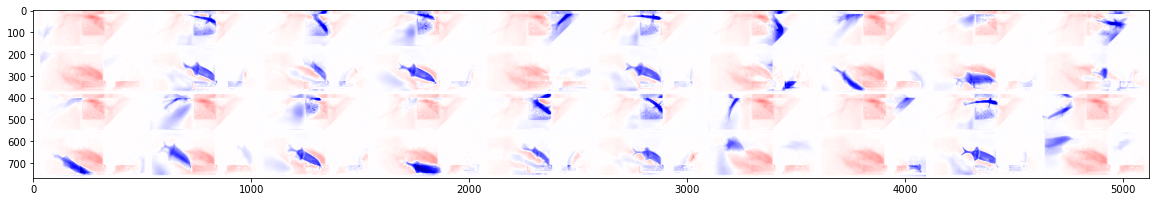

In [3]:
# k-means clustering
n_clusters = 20
kmeans = KMeansSampler(n_clusters=n_clusters, max_iter=1000, n_init=10, batch_size=100, verbose=True)
kmeans.fit(random_frames)
kmeans.plot_centers(n_rows=2)
kmeans_sampled_frames, kmeans_cluster_labels, frame_idxs = kmeans.sample_data(
    random_frames, n_samples_per_label=np.ceil(n_frames/n_clusters).astype('int'))

## make new dataset

In [28]:
# initialize dataset
initialize_dataset(
    images=kmeans_sampled_frames,
    datapath=join(git_dir, 'label', 'datasets', dataset_name+'.h5'),
    skeleton=skeleton,
    overwrite=False
)

## (or) add frames to existing dataset

In [8]:
# make merged dataset

old_dataset = r'D:\github\fish-tracking\label\datasets\tank_dataset_6.h5'
new_dataset = r'D:\github\fish-tracking\label\datasets\tank_dataset_7.h5'
initialize_predictions = True  # only works if video is analyzed

predictions = pd.read_csv(os.path.splitext(video)[0] + '_tracking.csv').to_numpy()[:,1:]
predictions = predictions.reshape((-1, int(predictions.shape[1]/3), 3))  # (frane_num X feature_num X (x,y,confidence))
predictions = predictions[random_idxs[frame_idxs]]

merge_new_images(
    datapath=old_dataset,
    merged_datapath=new_dataset,
    images=kmeans_sampled_frames,
    keypoints=predictions,
    overwrite=True
)


## change skeleton for existing dataset

In [17]:
from deepposekit.io.utils import update_skeleton
%load_ext autoreload
%autoreload 2

# settings
old_dataset = r'D:\github\fish-tracking\label\datasets\tank_dataset_2.h5'
new_dataset = r'D:\github\fish-tracking\label\datasets\tank_dataset_3.h5'
new_skeleton = r'D:\github\fish-tracking\label\skeletons\tank_skeleton_2.csv'

update_skeleton(old_dataset, new_dataset, new_skeleton)

## add skeleton_names to dataset

In [ ]:
# add skeleton names to dataset
from deepposekit.io.utils import initialize_skeleton
import h5py

# settings
dataset = r'D:\github\fish-tracking\label\datasets\tank_dataset_2.h5'
skeleton = r'D:\github\fish-tracking\label\skeletons\tank_skeleton_1.csv'

# get skeleton names
skeleton_names = initialize_skeleton(skeleton)
skeleton_names = skeleton_names['name'].values.astype('S32')
skeleton_names

# add to dataset
with h5py.File(dataset, 'r+') as file:
    file.create_dataset(
        "skeleton_names",
        (skeleton_names.shape[0],),
        dtype="S32",
        data=skeleton_names,
    )

# check it was successfully added
with h5py.File(dataset, 'r') as file:
    old_data = {key: value[...] for key, value in file.items()}
old_data.keys()


# change the names of skeleton parts
Make a spreadsheet with an `old_name` and `new_name` column. The old names will be replaced with the new names either in the skeleton file itself, or in the `skeleton_names` field associated with a dataset. The following code assumes the old and new skeleton files / datasets have all the same features; we are just changing the names of those features.

In [162]:
from shutil import copyfile
import pandas as pd
import numpy as np
import h5py

new_name_file = r'D:\github\fish-tracking\label\skeletons\tank_newnames.csv'
names = pd.read_csv(new_name_file)
old_names = names['old_name'].values.astype("S32")
new_names = names['new_name'].values.astype("S32")

In [166]:
# change skeleton_names field for a dataset

# settings
old_dataset = r'D:\github\fish-tracking\label\datasets\tank_dataset_3.h5'
new_dataset = r'D:\github\fish-tracking\label\datasets\tank_dataset_4.h5'

# create dataset with new names 
copyfile(old_dataset, new_dataset)
with h5py.File(new_dataset, 'r+') as f:
    f['skeleton_names'][...] = new_names

# check names in new dataset
with h5py.File(new_dataset, 'r') as f:
    name_check = f['skeleton_names'][...]
print('NAMES IN NEW FILE:')
print(name_check)
    

NAMES IN NEW FILE:
[b'head_main' b'chin_base_main' b'chin1_4_main' b'chin_half_main'
 b'chin3_4_main' b'chin_tip_main' b'mid_main' b'fork_main' b'stripeA_main'
 b'stripeP_main' b'tail_neck_main' b'dorsal_main' b'anal_main'
 b'caudal_d_main' b'caudal_v_main' b'pectoral_L_main' b'pectoral_R_main'
 b'pelvic_L_main' b'pelvic_R_main' b'head_top' b'chin_base_top'
 b'chin1_4_top' b'chin_half_top' b'chin3_4_top' b'chin_tip_top' b'mid_top'
 b'fork_top' b'stripeA_top' b'stripeP_top' b'tail_neck_top' b'dorsal_top'
 b'anal_top' b'caudal_d_top' b'caudal_v_top' b'pectoral_L_top'
 b'pectoral_R_top' b'pelvic_L_top' b'pelvic_R_top' b'head_right'
 b'chin_base_right' b'chin1_4_right' b'chin_half_right' b'chin3_4_right'
 b'chin_tip_right' b'mid_right' b'fork_right' b'stripeA_right'
 b'stripeP_right' b'tail_neck_right' b'dorsal_right' b'anal_right'
 b'caudal_d_right' b'caudal_v_right' b'pectoral_L_right'
 b'pectoral_R_right' b'pelvic_L_right' b'pelvic_R_right'
 b'stage_left_floor_main' b'stage_right_floor_

In [165]:
# create new csv with updated skeleton names

# settings
old_skeleton = r'D:\github\fish-tracking\label\skeletons\tank_skeleton_2.csv'
new_skeleton = r'D:\github\fish-tracking\label\skeletons\tank_skeleton_3.csv'
    
# replace name column
df = pd.read_csv(old_skeleton)
idx = np.concatenate([np.where(n==old['name'].values.astype("S32"))[0] for n in old_names])
df['name'] = new_names[idx].astype('str')

# replace parent column
idx = np.concatenate([np.where(n==old['parent'].values.astype("S32"))[0] for n in old_names])
idx = np.concatenate([np.where(n==old_names)[0] for n in old['parent'].values.astype("S32")])
row_bins = ~df['parent'].isnull().values
df.loc[row_bins, 'parent'] = new_names[idx].astype('str')

# save
df.to_csv(new_skeleton, index=False)
print('NEW SPREADSHEET:')
df

NEW SPREADSHEET:


,name,parent,swap
0,head_main,NaN,NaN
1,chin_base_main,head_main,NaN
2,chin1_4_main,chin_base_main,NaN
3,chin_half_main,chin1_4_main,NaN
4,chin3_4_main,chin_half_main,NaN
...,...,...,...
103,well_above_BL_top,well_above_BR_top,NaN
104,well_side_TL_right,NaN,NaN
105,well_side_TR_right,well_side_TL_right,NaN
106,well_side_BR_right,well_side_TR_right,NaN
